In [16]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_5383/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [4]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/saved_models_2.0"
# train/val/test dir
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"
test_data_file_path = data_dir + "preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

In [5]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [6]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)

Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [7]:
# can be skipped
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]

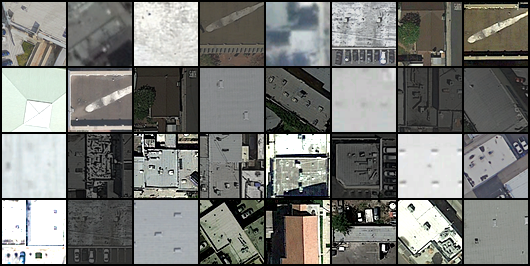

In [6]:
# Check to see if data is loaded 
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [8]:
# Set default parameters
image_channels = fixed_x.size(1)
img_dim = fixed_x.size(-1)

In [9]:
def loss_fn(recon_x, x, mu, logvar,beta=1.0):
    x = x.to(device)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    KLD*=beta
    return BCE + KLD, BCE, KLD

In [14]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim=img_dim,image_channels=image_channels,z_dim=128,device=device).to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# Train VAE

In [71]:
filename = model_dir+'\\roofnet_VAE_test_gradcam.pth'
epochs = 50
bs=32
train = True

# the path for saving GradCAM maps
gradcam_maps_path = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/gradcam_maps"


if train:

    start_time = time.time()  # record the start time

    epoch = 0
    while epoch < epochs:
        
        for idx in range(100):
            images = next(iter(dataloader))
            images = images[0]
            recon_images,z, mu, logvar = model(images.to(device))
            loss, bce, kld = loss_fn(recon_images, images, mu, logvar, beta=5.0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.item()/bs, bce.item()/bs, kld.item()/bs)
        epoch += 1
        print(to_print)
        
        # Save GradCAM maps for specific epochs
        if epoch in [20, 30, 40, 50]:
            gradcam_maps = gradcam.generate(images)  # Generate GradCAM maps
            epoch_folder = os.path.join(gradcam_maps_path, f"epoch_{epoch}")
            os.makedirs(epoch_folder, exist_ok=True)  # Create folder for the epoch if it doesn't exist

            # Save GradCAM maps in the epoch folder
            save_path = os.path.join(epoch_folder, f"gradcam_map_epoch{epoch}_iter{idx + 1}.png")
            save_image(gradcam_maps, save_path)





    torch.save(model.state_dict(),  filename)
    end_time = time.time()  # record the end time
    training_time = end_time - start_time  # calculate the training time in seconds
    print("Training time: {:.2f} seconds".format(training_time))

c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[1/50] Loss: 7300.232 7300.109 0.123


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[2/50] Loss: 7048.856 7048.381 0.475


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[3/50] Loss: 7239.259 7238.816 0.443


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[4/50] Loss: 7125.799 7125.217 0.582


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[5/50] Loss: 6808.188 6807.474 0.714


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[6/50] Loss: 7313.223 7312.722 0.502


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[7/50] Loss: 6822.928 6822.224 0.704


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[8/50] Loss: 6806.989 6806.269 0.721


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[9/50] Loss: 7357.512 7356.914 0.597


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[10/50] Loss: 7407.902 7407.368 0.534


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[11/50] Loss: 7037.278 7036.580 0.698


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[12/50] Loss: 6220.701 6219.917 0.784


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[13/50] Loss: 7080.209 7079.554 0.655


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[14/50] Loss: 7362.708 7362.154 0.553


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[15/50] Loss: 6557.040 6556.310 0.730


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[16/50] Loss: 7230.625 7230.092 0.534


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[17/50] Loss: 6988.062 6987.484 0.577


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[18/50] Loss: 6985.468 6984.816 0.652


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[19/50] Loss: 6921.918 6921.254 0.664


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[20/50] Loss: 6753.173 6752.429 0.745


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[21/50] Loss: 6875.517 6874.817 0.699


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[22/50] Loss: 6907.357 6906.723 0.634


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[23/50] Loss: 6257.035 6256.102 0.933


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[24/50] Loss: 6803.759 6802.990 0.769


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[25/50] Loss: 7267.796 7267.217 0.579


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[26/50] Loss: 6424.222 6423.403 0.819


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[27/50] Loss: 6637.350 6636.597 0.753


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[28/50] Loss: 6826.867 6826.210 0.657


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[29/50] Loss: 7094.448 7093.760 0.687


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[30/50] Loss: 7091.388 7090.765 0.623


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[31/50] Loss: 6607.060 6606.248 0.811


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[32/50] Loss: 6877.703 6876.959 0.744


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[33/50] Loss: 7152.124 7151.477 0.647


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[34/50] Loss: 6362.931 6362.098 0.834


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[35/50] Loss: 6437.705 6436.896 0.809


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[36/50] Loss: 6315.531 6314.721 0.809


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[37/50] Loss: 6301.967 6301.212 0.755


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[38/50] Loss: 6691.971 6691.307 0.664


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[39/50] Loss: 6746.556 6745.788 0.768


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[40/50] Loss: 6816.738 6816.075 0.663


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[41/50] Loss: 6299.650 6298.854 0.797


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[42/50] Loss: 6868.349 6867.610 0.739


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[43/50] Loss: 7068.433 7067.665 0.768


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[44/50] Loss: 7173.085 7172.337 0.748


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[45/50] Loss: 7119.914 7119.299 0.615


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[46/50] Loss: 7024.379 7023.719 0.660


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[47/50] Loss: 7007.680 7007.031 0.648


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[48/50] Loss: 7212.267 7211.571 0.696


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[49/50] Loss: 6828.193 6827.481 0.712


c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\python\python35\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
c:\py

Epoch[50/50] Loss: 6447.559 6446.721 0.838


# Compare real image and reconstruction

Note: VAEs are known to generate blurry. The reason is that the latent code is trying to compress as much info as possible and only focus on the meaningful features.

In [47]:
#64x64
model = roofnet.models.vae.VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir+'\\roofnet_VAE_Beta1.pth'))
val_data_file_path = data_dir + "\\val_64_noreroofs.npy"

In [86]:
#255x255
model = roofnet.models.vae.VAE(img_dim=255,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir+'\\roofnet_hard.pth'))
val_data_file_path = data_dir + "\\test_easy.npy"

In [11]:
def compare(x):
    x=x.to(device)
    recon_x,_, _, _ = model(x)
    return torch.cat([x, recon_x])

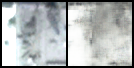

In [48]:
fixed_x = next(iter(dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

# Use validation data to make predicitons

In [25]:
transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
val_data = ImageDataset(val_data_file_path,
                    transform=transform_chain)

Loading data
Done loading data
Length 294
Num Roofs 42


In [26]:
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=7, shuffle=False)
val_dataloader = iter(val_dataloader)

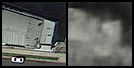

In [32]:
fixed_x = next(iter(val_dataloader))[0][:1]
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))

In [33]:
out = []
latents = []
meta = []
for i in val_dataloader:
    images = i[0]
    recon_images,z, _, _ = model(images.to(device))
    z = z.detach().cpu().numpy()
    latents.append(z)
    meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])
    d = int(np.argmax([np.linalg.norm(zi-zj) for zi,zj in zip(z[1:],z[:-1])]))+2013
    out.append([i[2]['address'][0],d,int(i[2]['transition_year'][0].cpu().numpy())])
out = np.array(out)
latents = np.array(latents)

In [529]:
hold = 0
l = 0
for i in out:
    if i[2] != 0:
        l += 1
        if i[1]==i[2]:
            hold += 1
print(hold/l)

0.6333333333333333


Looking at just the argmax of distance between latents does not produce a great accuracy. There are clearly many images where the largest distance between latents is a terrible metric for reroof. The verticle bar represents the reroof date, if it is missing there is no reroof.

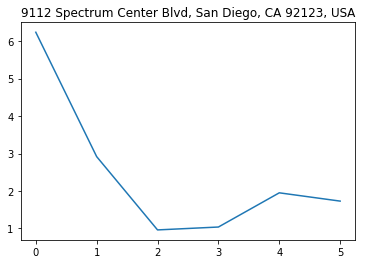

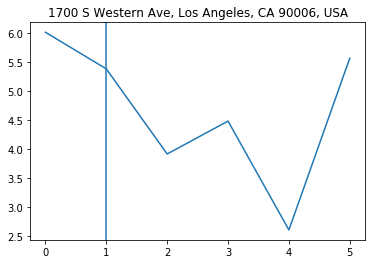

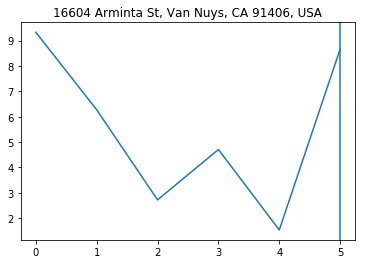

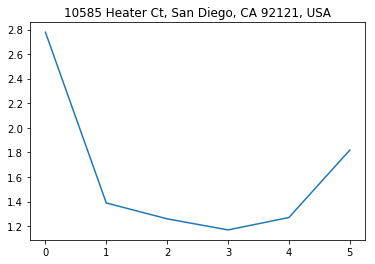

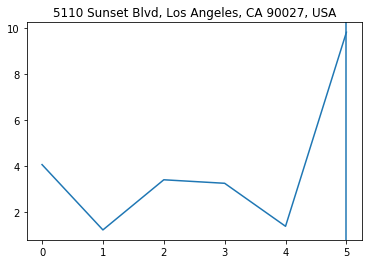

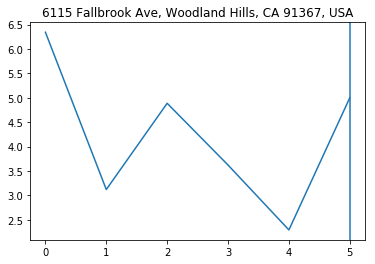

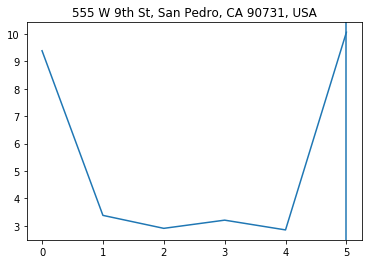

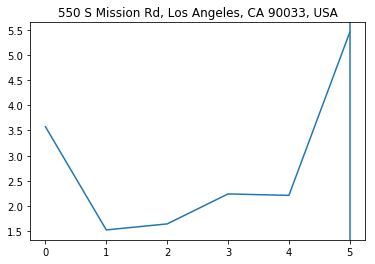

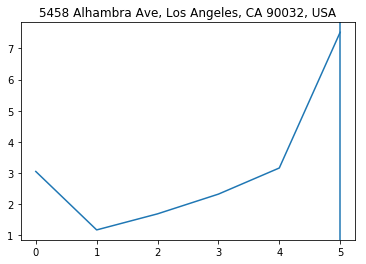

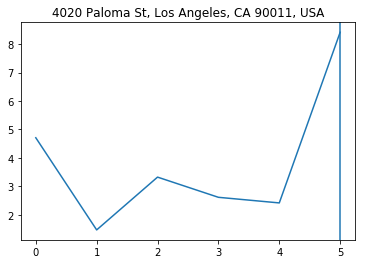

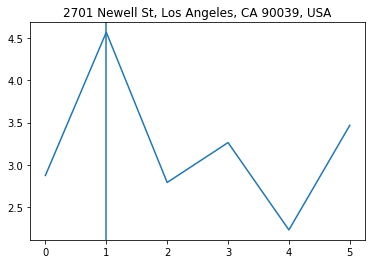

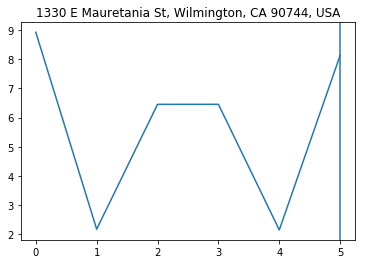

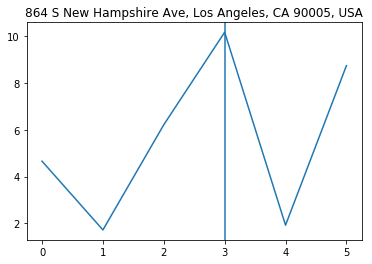

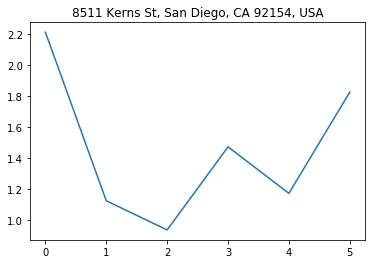

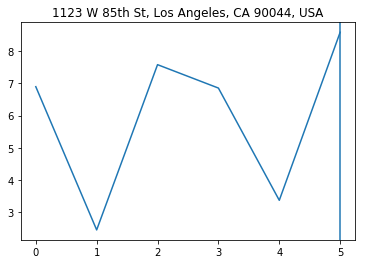

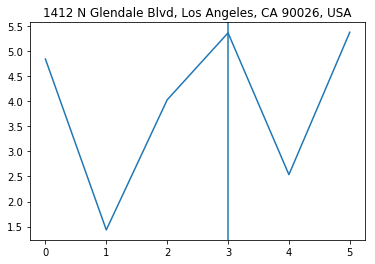

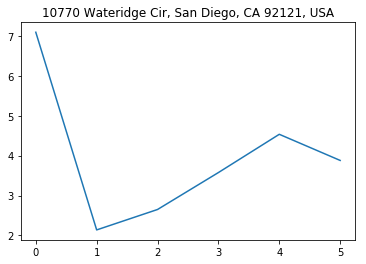

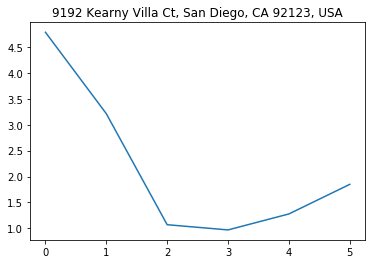

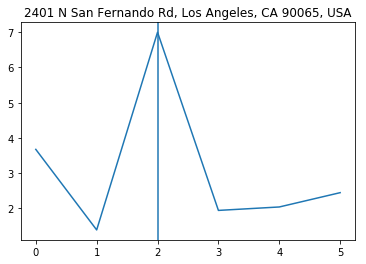

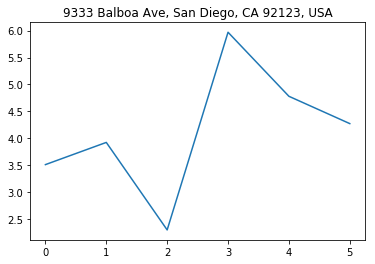

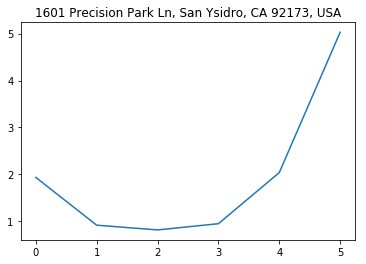

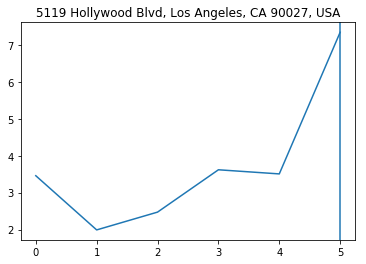

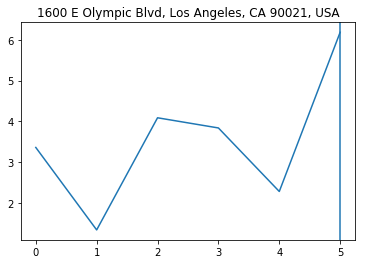

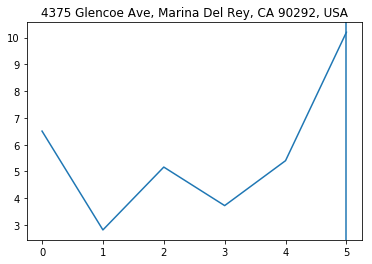

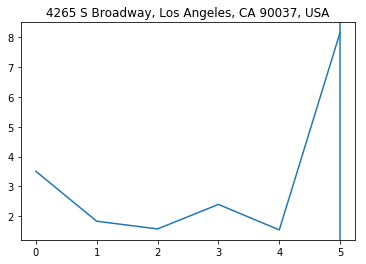

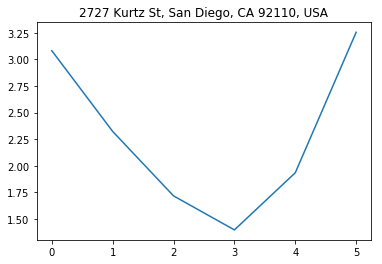

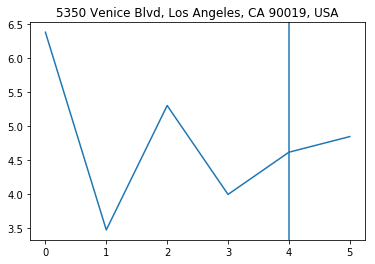

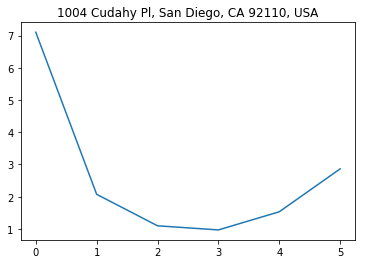

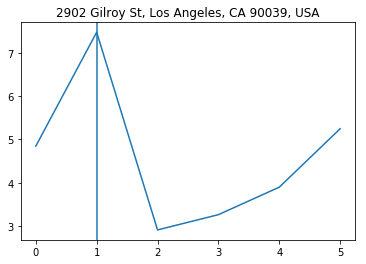

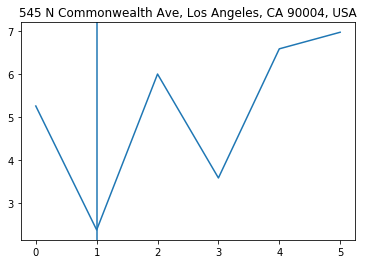

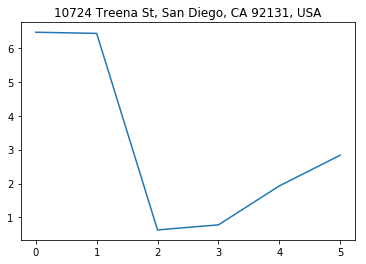

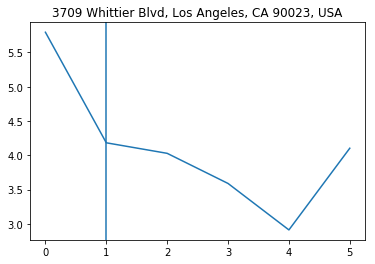

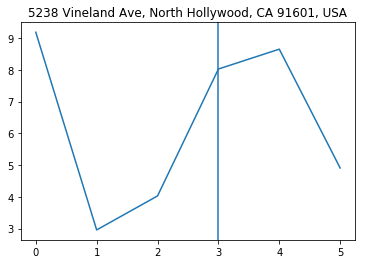

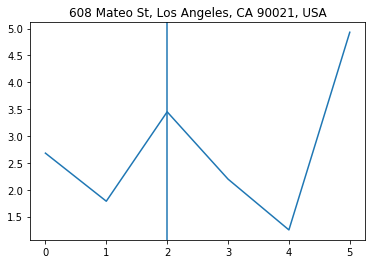

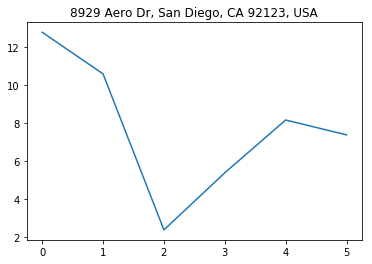

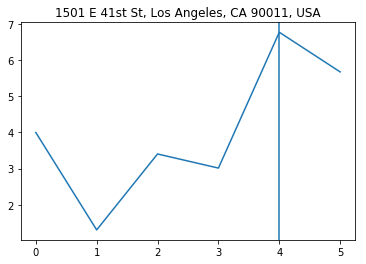

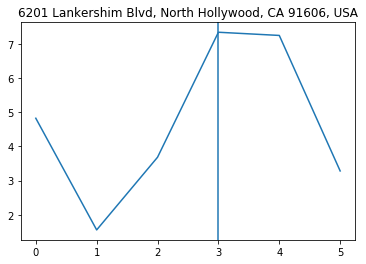

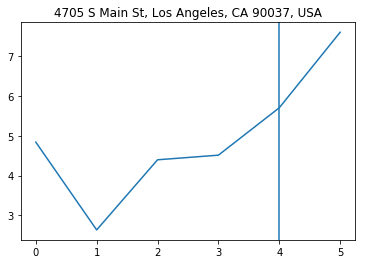

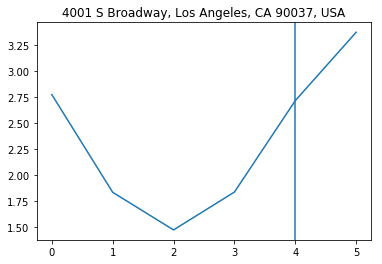

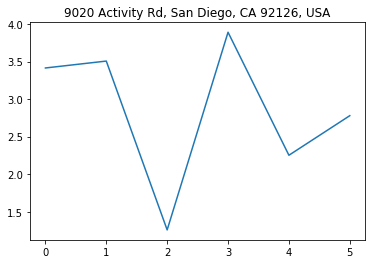

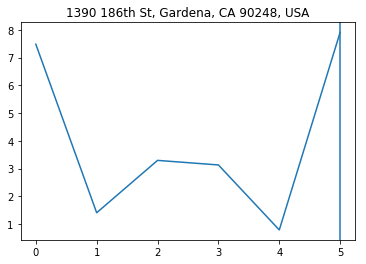

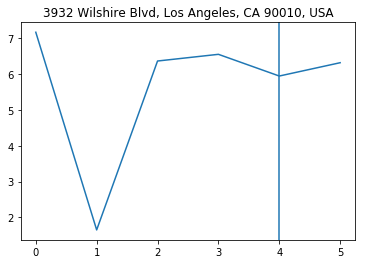

In [46]:
for j in range(len(latents)):
    diff = []
    for i in range(6):
        diff.append(np.linalg.norm(latents[j][i]-latents[j][i+1]))
    plt.plot(diff)
    plt.title(meta[j][0])
    if meta[j][1] != 0:
        plt.axvline(int(meta[j][1])-2013)
    plt.show()

# Build binary classifier on latents

In [26]:
from torch.autograd import Variable

## Helper functions:

In [14]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):
    v_1 = np.hstack((latent_1,latent_2))
    v_2 = np.hstack((latent_2,latent_1))
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device))
    p_2 = net(torch.tensor(v_2).to(device))
    prob = max([p_1.item(),p_2.item()])
    return prob >= prob_threshold

In [15]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
def gen_predictions(latents,meta,model,prob_threshold=0.5):
    out = []
    for i in range(len(latents)):
        hold = []
        hold.append(str(meta[i][0]))
        trans_year = 0
        for j in range(len(latents[i])-1):
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold):
                trans_year = j + 2013
                break
        hold.append(trans_year)
        hold.append(int(meta[i][1]))
        out.append(hold)
    return np.array(out)

In [31]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
def get_max_prob(latents,meta,model,prob_threshold=0.5):
    out = []
    for i in range(len(latents)):
        hold = []
        hold.append(str(meta[i][0]))
        trans_year = 0
        temp = []
        for j in range(len(latents[i])-1):
            latent_1 = latents[i][j]
            latent_2 = latents[i][j+1]
            v_1 = np.hstack((latent_1,latent_2))
            v_2 = np.hstack((latent_2,latent_1))
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device))
            p_2 = net(torch.tensor(v_2).to(device))
            prob = max([p_1.item(),p_2.item()])
            temp.append(prob)
        index = np.argmax(temp)
        if temp[index]>=prob_threshold:
            trans_year = 2013 + index
        hold.append(trans_year)
        hold.append(int(meta[i][1]))
        out.append(hold)
    return np.array(out)

In [ ]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):
    no_reroof_pred = []
    reroof_pred = []
    hold = acc_metric(latents,meta,net,threshold)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [ ]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [ ]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
def gen_latents(dataloader, model):
    latents = []
    meta = []
    for i in dataloader:
        images = i[0]
        _, z, _, _ = model(images.to(device))
        z = z.detach().cpu().numpy()
        latents.append(z)
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])
    latents = np.array(latents)
    return latents, meta

In [ ]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
def gen_binary_data(latents, meta):
    data_hold = []
    label_hold = []
    for i in range(len(latents)):
        for j in range(len(latents[i])):
            for k in range(len(latents[i])):
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))
                year_j = 2012+j < meta[i][1]
                year_k = 2012+k < meta[i][1]
                label_hold.append(float(year_j != year_k))
    data_hold = np.array(data_hold)
    label_hold = np.array(label_hold)
    
    return data_hold, label_hold

In [16]:
def binary_train_epoch(model, opt, criterion, data, labels, data_loader, val_data, val_labels, val_data_loader, best_acc, logit=False):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    model.train()
    loss_hold = []
    
    for i in iter(data_loader):
        batch_size = len(i)
        x_batch = data[i]
        y_batch = labels[i]
        
        x_batch = Variable(torch.from_numpy(x_batch))
        y_batch = torch.tensor(y_batch, dtype=torch.float, device=device)
        y_batch = y_batch.view(batch_size,-1)
        
        opt.zero_grad()
        y_hat = model(x_batch.to(model.device))
        loss = criterion(y_hat,y_batch)
        loss.backward()
        opt.step()
        
        loss_hold.append(loss.item()/batch_size)
    print("Epoch training loss:{:.3f}".format(np.mean(loss_hold)))
    
    #validate
    model.eval()
    pred_acc = []
    for i in iter(val_data_loader):
        batch_size = len(i)
        x_batch = val_data[i]
        y_batch = val_labels[i]
        
        x_batch = Variable(torch.from_numpy(x_batch))
        
        if logit:
            y_logits = model(x_batch.to(model.device))
            s = nn.Sigmoid()
            y_hat = s(y_logits)>0.5
        else:
            y_hat = model(x_batch.to(model.device))>0.5
        
        pred_acc.append(np.mean(y_hat.cpu().numpy() == y_batch.reshape(batch_size,-1)))
        
    pred_acc = np.mean(pred_acc)
    print("Epoch validation accuracy: {:.3f}%".format(pred_acc))
    
    if pred_acc >= best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = pred_acc
    
    net.load_state_dict(best_model_wts)
    
    return net, best_acc
        
        

## Load the data

In [91]:
model = roofnet.models.vae.VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir+'\\roofnet_VAE_Beta5.pth'))

data_file_path = data_dir + "\\train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [92]:
val_data_file_path = data_dir + "\\val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [93]:
test_data_file_path = data_dir + "\\test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [94]:
latents, meta = gen_latents(binary_dataloader, model)

In [95]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)

In [96]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)

In [97]:
data_hold, label_hold = gen_binary_data(latents, meta)

In [98]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)

In [99]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)

## Define the model

In [100]:
class Net(nn.Module):
    
    def __init__(self, zdim = 128):
        super().__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.network = nn.Sequential(
            nn.Linear(2*zdim, 2*zdim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2*zdim, zdim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(zdim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        ).to(self.device)
              
    
    def forward(self, x):
        y = self.network(x)
        return y
    
net = Net()
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [101]:
index_loader = torch.utils.data.DataLoader(np.arange(len(data_hold)),batch_size=32,shuffle=True)
val_index_loader = torch.utils.data.DataLoader(np.arange(len(val_hold)),batch_size=32,shuffle=True)

## Train the model:

In [102]:
num_epochs = 10
best_acc = 0
for e in range(num_epochs):
    print('Running epoch {}/{}'.format(e,num_epochs))
    net, best_acc = binary_train_epoch(net, opt, criterion, data_hold, label_hold, index_loader, val_hold, val_label, val_index_loader, best_acc)

Running epoch 0/10
Epoch training loss:0.015
Epoch validation accuracy: 0.854%
Running epoch 1/10
Epoch training loss:0.009
Epoch validation accuracy: 0.895%
Running epoch 2/10
Epoch training loss:0.007
Epoch validation accuracy: 0.893%
Running epoch 3/10
Epoch training loss:0.007
Epoch validation accuracy: 0.901%
Running epoch 4/10
Epoch training loss:0.006
Epoch validation accuracy: 0.901%
Running epoch 5/10
Epoch training loss:0.005
Epoch validation accuracy: 0.900%
Running epoch 6/10
Epoch training loss:0.005
Epoch validation accuracy: 0.893%
Running epoch 7/10
Epoch training loss:0.005
Epoch validation accuracy: 0.910%
Running epoch 8/10
Epoch training loss:0.004
Epoch validation accuracy: 0.894%
Running epoch 9/10
Epoch training loss:0.005
Epoch validation accuracy: 0.899%


In [62]:
# Earliest transition method prediction:
hold = gen_metrics(gen_predictions, val_latents, val_meta, net)

Overall accuracy: 0.840
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.733


In [170]:
net.load_state_dict(torch.load(model_dir+'\\roofnet_binary_class_hard_easyval.pth'))

<All keys matched successfully>

In [106]:
torch.save(net.state_dict(), model_dir+'\\roofnet_binary_class_b5.pth')

In [103]:
hold = gen_metrics(get_max_prob, val_latents, val_meta, net)

Overall accuracy: 0.800
No reroof prediction accuracy: 0.900
Reroof prediction accuracy: 0.733


In [104]:
hold = gen_metrics(get_max_prob, test_latents, test_meta, net)

Overall accuracy: 0.691
No reroof prediction accuracy: 0.800
Reroof prediction accuracy: 0.600


In [88]:
out = {'site_address': hold[:,0], 'transition_true': hold[:,2], 'transition_predicted': hold[:,1]}

In [89]:
import pandas as pd

In [105]:
pd.DataFrame(out).to_csv('Argmax(Prob) Beta5.csv')

Hyperparameter tuning on prediction threshold, best to leave at 0.5:

In [67]:
#out = [Address, predicted_transition, actual_transition]
for i in range(21):
    pt = 0.4+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(val_latents,val_meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.4
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.41000000000000003
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.42000000000000004
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.43000000000000005
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.44
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.45
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.46
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 0.800
--------------------
0.47000000000000003
Overall accuracy: 0.880
No reroof prediction accuracy: 1.000
Reroof prediction accuracy: 

In [157]:
#out = [Address, predicted_transition, actual_transition]
for i in range(11):
    pt = 0.3+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.3
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.31
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.32
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.32999999999999996
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.33999999999999997
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.35
Overall accuracy: 0.633
No reroof prediction accuracy: 0.611
Reroof prediction accuracy: 0.645
--------------------
0.36
Overall accuracy: 0.653
No reroof prediction accuracy: 0.667
Reroof prediction accuracy: 0.645
--------------------
0.37
Overall accuracy: 0.633
No reroof prediction accuracy: 0.667
Reroof prediction accuracy: 0.613
--------------------
0.3

In [158]:
#out = [Address, predicted_transition, actual_transition]
for i in range(21):
    pt = 0.1+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.1
Overall accuracy: 0.592
No reroof prediction accuracy: 0.444
Reroof prediction accuracy: 0.677
--------------------
0.11
Overall accuracy: 0.592
No reroof prediction accuracy: 0.444
Reroof prediction accuracy: 0.677
--------------------
0.12000000000000001
Overall accuracy: 0.592
No reroof prediction accuracy: 0.444
Reroof prediction accuracy: 0.677
--------------------
0.13
Overall accuracy: 0.592
No reroof prediction accuracy: 0.444
Reroof prediction accuracy: 0.677
--------------------
0.14
Overall accuracy: 0.592
No reroof prediction accuracy: 0.444
Reroof prediction accuracy: 0.677
--------------------
0.15000000000000002
Overall accuracy: 0.612
No reroof prediction accuracy: 0.500
Reroof prediction accuracy: 0.677
--------------------
0.16
Overall accuracy: 0.612
No reroof prediction accuracy: 0.500
Reroof prediction accuracy: 0.677
--------------------
0.17
Overall accuracy: 0.612
No reroof prediction accuracy: 0.500
Reroof prediction accuracy: 0.677
--------------------
0.1

In [174]:
#out = [Address, predicted_transition, actual_transition]
for i in range(21):
    pt = 0.4+0.01*i
    print(pt)
    no_reroof_pred = []
    reroof_pred = []
    hold = get_max_prob(latents,meta,net,prob_threshold=pt)
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2])))
    for i in hold:
        if int(i[2])==0:
            no_reroof_pred.append(int(int(i[1]) == 0))
        else:
            reroof_pred.append(int(i[1]==i[2]))
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    print('-'*20)

0.4
Overall accuracy: 0.382
No reroof prediction accuracy: 0.833
Reroof prediction accuracy: 0.286
--------------------
0.41000000000000003
Overall accuracy: 0.380
No reroof prediction accuracy: 0.845
Reroof prediction accuracy: 0.281
--------------------
0.42000000000000004
Overall accuracy: 0.378
No reroof prediction accuracy: 0.845
Reroof prediction accuracy: 0.278
--------------------
0.43000000000000005
Overall accuracy: 0.380
No reroof prediction accuracy: 0.857
Reroof prediction accuracy: 0.278
--------------------
0.44
Overall accuracy: 0.376
No reroof prediction accuracy: 0.857
Reroof prediction accuracy: 0.273
--------------------
0.45
Overall accuracy: 0.370
No reroof prediction accuracy: 0.857
Reroof prediction accuracy: 0.266
--------------------
0.46
Overall accuracy: 0.361
No reroof prediction accuracy: 0.857
Reroof prediction accuracy: 0.256
--------------------
0.47000000000000003
Overall accuracy: 0.357
No reroof prediction accuracy: 0.869
Reroof prediction accuracy: 

KeyboardInterrupt: 